In [ ]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from natsort import natsorted
import matplotlib.pyplot as plt

In [ ]:
gm_data = [file for file in glob.glob("data/trained_models/2025-07-23-11/*.csv")]
k5_data = [file for file in (glob.glob("data/trained_models/2025-07-25-14/*.csv"))]

In [ ]:
data = natsorted(gm_data + k5_data)
cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
gm_h5 = h5py.File("data/EPInformer/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5")
k5_h5 = h5py.File("data/EPInformer/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5")

In [ ]:
gm_cage = cage[["ENSID", "GM12878_CAGE_128*3_sum"]]
k5_cage = cage[["ENSID", "K562_CAGE_128*3_sum"]]

In [ ]:
def decode_and_plot(ensid_folds, h5):
    # Grabs the rows that match the condition we set (negative predictions, error threshold, etc).
    ensid, folds = zip(*ensid_folds)
    bool_df = [gene.decode() in ensid for gene in h5["ensid"]]
    rna_signals = h5["rna"][:][bool_df]

    # Only look at the genes that have a signal.
    filtered_0s = rna_signals[np.any(rna_signals != 0, axis = 1)]
    signal_index = np.where(np.any(rna_signals != 0, axis = 1))[0]
    only_0s_index = np.where(np.all(rna_signals == 0, axis = 1))[0]
    tss_signal = [gene.decode() for gene in h5["ensid"][:][signal_index]]
    tss_no_signal = [gene.decode() for gene in h5["ensid"][:][only_0s_index]]

    print(f"Total Number of Matches: {len(rna_signals)}")
    print(f"Total Matches with >= 1 Non-Zero Value: {len(filtered_0s)}")
    print(f"Percentage of TSSs with No Signal: {(len(rna_signals) - len(filtered_0s)) / len(rna_signals) * 100:.2f}%")

    print(f"Genes w/ Signal: {tss_signal}")
    print(f"Genes w/o Signal: {tss_no_signal}")

    for signal in filtered_0s:
        plt.plot(signal)
    
    return signal_index, only_0s_index

In [ ]:
def test_thresholds(dict, h5, conditional_column, thresholds, operand, path, cell_line):
    # Grab the ENSIDs that fit our condition.
    ensid_matches = None
    fold_matches = None
    for threshold in thresholds:
        if operand == "g":
            ensid_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 3])
        elif operand == "ge":
            ensid_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 3])
        elif operand == "l":
            ensid_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 3])
        elif operand == "le":
            ensid_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 3])
        elif operand == "eq":
            ensid_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 3])

        print(f"Threshold: {threshold}")
        print("Genes per Fold: ")
        for i, c in pd.Series(fold_matches).value_counts().sort_index().items():
            print(f"{i}: {c}")
        signal_index, only_0s_index = decode_and_plot(zip(ensid_matches, fold_matches), h5)
        plt.savefig(f"{path}/{cell_line}.png")
        plt.show()
        # plt.clf()

        return signal_index, only_0s_index

In [ ]:
results_dict = {}
results_dict["GM12878"] = pd.DataFrame()
results_dict["K562"] = pd.DataFrame()
for file in data:
    df = pd.read_csv(file)
    if "GM12878" in file:
        results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    else:
        results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

results_dict["GM12878"] = results_dict["GM12878"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)
results_dict["K562"] = results_dict["K562"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)

print(f"Num Rows (GM12878): {len(results_dict["GM12878"])}")
print(f"Num Rows (K562): {len(results_dict["K562"])}")

In [ ]:
for key in results_dict.keys():
    print(f"{key}: ")
    results_dict[key]["Error"] = abs(results_dict[key]["Pred"] - results_dict[key]["actual"])
    results_dict[key]["Signed Error"] = results_dict[key]["Pred"] - results_dict[key]["actual"]

    print(f"Mean Error per Fold:\n{results_dict[key].groupby("fold_idx")["Error"].mean()}")

    print(f"\nMax Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().max()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmax()}")

    print(f"\nMin Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().min()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmin()}")

    print(f"\nMean Error: {results_dict[key]["Error"].mean()}")

    print(f"\nMax Error: {results_dict[key]["Error"].max()}")

    print(f"\nMin Error: {results_dict[key]["Error"].min()} \n")

gm = results_dict["GM12878"]
k5 = results_dict["K562"]

Negative Predictions

In [ ]:
print("GM12878: ")
gm_neg_pred_signal, gm_neg_pred_no_signal = test_thresholds(gm, gm_h5, "Pred", [0], "l", "predictions/neg_preds", "GM12878")

print("K562: ")
k5_neg_pred_signal, k5_neg_pred_no_signal = test_thresholds(k5, k5_h5, "Pred", [0], "l", "predictions/neg_preds", "K562")

Low Errors

In [ ]:
gm["Error"].quantile([0.01, 0.05, 0.1])

In [ ]:
k5["Error"].quantile([0.01, 0.05, 0.1])

In [ ]:
print("GM12878: ")
gm_low_error_signal, gm_low_error_no_signal = test_thresholds(gm, gm_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/low_errors", "GM12878")

print("K562: ")
k5_low_error_signal, k5_low_error_no_signal = test_thresholds(k5, k5_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/low_errors", "K562")

High Errors

In [ ]:
gm["Error"].quantile([0.9, 0.95, 0.99])

In [ ]:
k5["Error"].quantile([0.9, 0.95, 0.99])

In [ ]:
print("GM12878: ")
gm_high_error_signal, gm_high_error_no_signal = test_thresholds(gm, gm_h5, "Error", [1, 1.5, 2], "g", "predictions/high_errors", "GM12878")

print("K562: ")
k5_high_error_signal, k5_high_error_no_signal = test_thresholds(k5, k5_h5, "Error", [1, 1.5, 2], "g", "predictions/high_errors", "K562")

Overestimates

In [ ]:
print("GM12878: ")
gm_over_signal, gm_over_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "l", "predictions/overestimates", "GM12878")

print("K562")
k5_over_signal, k5_over_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "l", "predictions/overestimates", "K562")

Underestimates

In [ ]:
print("GM12878: ")
gm_under_signal, gm_under_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "g", "predictions/underestimates", "GM12878")

print("K562")
k5_under_signal, k5_under_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "g", "predictions/underestimates", "K562")

In [ ]:
n = 5

Worst Errors (Over Expressed)

In [ ]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Signed Error"] = pd.to_numeric(over_df_gm["Signed Error"])
    over_df_5_worst_gm = over_df_gm.nlargest(n, columns=["Signed Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Signed Error"] = pd.to_numeric(over_df_k5["Signed Error"])
    over_df_5_worst_k5 = over_df_k5.nlargest(n, columns=["Signed Error"])

print("GM12878: ")
display(over_df_5_worst_gm)

print("K562: ")
display(over_df_5_worst_k5)

In [ ]:
# Individual Plots
signal_5_worst_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_over_gm):
    plt.plot(signal_5_worst_over_gm[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/overestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_over_k5):
    plt.plot(signal_5_worst_over_k5[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/overestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

Worst Errors (Under Expressed)

In [ ]:
with pd.option_context("mode.chained_assignment", None):
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Signed Error"] = pd.to_numeric(under_df_gm["Signed Error"])
    under_df_5_worst_gm = under_df_gm.nsmallest(n, columns=["Signed Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Signed Error"] = pd.to_numeric(under_df_k5["Signed Error"])
    under_df_5_worst_k5 = under_df_k5.nsmallest(n, columns=["Signed Error"])

print("GM12878: ")
display(under_df_5_worst_gm)

print("K562: ")
display(under_df_5_worst_k5)

In [ ]:
# Individual Plots
signal_5_worst_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

# signal_5_worst_under_gm = 10 ** signal_5_worst_under_gm - 1
# signal_5_worst_under_k5 = 10 ** signal_5_worst_under_k5 - 1

ensid_5_worst_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_worst_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_under_k5):
    plt.plot(signal_5_worst_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

Best Errors (Over Expressed)

In [ ]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Error"] = pd.to_numeric(over_df_gm["Error"])
    over_df_5_best_gm = over_df_gm.nsmallest(n, columns=["Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Error"] = pd.to_numeric(over_df_k5["Error"])
    over_df_5_best_k5 = over_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(over_df_5_best_gm)

print("K562: ")
display(over_df_5_best_k5)

In [ ]:
# Individual Plots
signal_5_best_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_best_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_over_gm):
    plt.plot(signal_5_best_over_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/overestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_over_k5):
    plt.plot(signal_5_best_over_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/overestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

Best Errors (Under Expressed)

In [ ]:
with pd.option_context("mode.chained_assignment", None): 
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Error"] = pd.to_numeric(under_df_gm["Error"])
    under_df_5_best_gm = under_df_gm.nsmallest(n, columns=["Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Error"] = pd.to_numeric(under_df_k5["Error"])
    under_df_5_best_k5 = under_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(under_df_5_best_gm)

print("K562: ")
display(under_df_5_best_k5) 

In [ ]:
# Individual Plots
signal_5_best_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

# signal_5_best_under_gm = 10 ** signal_5_best_under_gm - 1
# signal_5_best_under_k5 = 10 ** signal_5_best_under_k5 - 1

ensid_5_best_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_best_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_under_k5):
    plt.plot(signal_5_best_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

Zero Signal (Actual)

In [ ]:
print("GM12878: ")
gm_no_signal_actual = test_thresholds(gm, gm_h5, "actual", [0], "eq", "predictions/zero", "GM12878")

print("K562: ")
k5_no_signal_actual = test_thresholds(k5, k5_h5, "actual", [0], "eq", "predictions/zero", "K562")

Aggregate FP, FN, TP, TN

In [ ]:
# GM12878
best_score = 0
best_threshold = 0
for threshold in np.linspace(0, 5, 100):
    # preds = [1 if pred > threshold else 0 for pred in gm["Pred"]]
    # actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    preds = [actuals[idx] if gm["Error"].iloc[idx] < 1.5 else 1 - actuals[idx] for idx, pred in gm["Pred"].items()]
    score = f1_score(actuals, preds)
    if score > best_score:
        best_score = score
        best_threshold = threshold
print(f"Best Threshold: {best_threshold} w/ {best_score} F1 Score")
pred_actual = {
    "ENSID": gm["Unnamed: 0"],
    # "Pred" : [1 if pred > best_threshold else 0 for pred in gm["Pred"]],
    # "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "Pred": [gm["actual"].iloc[idx] > best_threshold if gm["Error"].iloc[idx] < 1.5 else 1 - (gm["actual"].iloc[idx] > best_threshold) for idx, pred in gm["Pred"].items()],
    "fold_idx": gm["fold_idx"]
}
gm_binary = pd.DataFrame(pred_actual) 

# K562
best_score = 0
best_threshold = 0
for threshold in np.linspace(0, 5, 100):
    # preds = [1 if pred > threshold else 0 for pred in gm["Pred"]]
    # actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    actuals = [1 if actual > threshold else 0 for actual in k5["actual"]]
    preds = [actuals[idx] if k5["Error"].iloc[idx] < 1.5 else 1 - actuals[idx] for idx, pred in k5["Pred"].items()]
    score = f1_score(actuals, preds)
    if score > best_score:
        best_score = score
        best_threshold = threshold
print(f"Best Threshold: {best_threshold} w/ {best_score} F1 Score")
pred_actual = {
    "ENSID": k5["Unnamed: 0"],
    # "Pred" : [1 if pred > best_threshold else 0 for pred in gm["Pred"]],
    # "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "actual" : [1 if actual > best_threshold else 0 for actual in k5["actual"]],
    "Pred": [k5["actual"].iloc[idx] > best_threshold if k5["Error"].iloc[idx] < 1.5 else 1 - (k5["actual"].iloc[idx] > best_threshold) for idx, pred in k5["Pred"].items()],
    "fold_idx": k5["fold_idx"]
}
k5_binary = pd.DataFrame(pred_actual) 


In [ ]:
# GM12878
fp_gm = gm_binary[(gm_binary["Pred"] == 1) & (gm_binary["actual"] == 0)]
fn_gm = gm_binary[(gm_binary["Pred"] == 0) & (gm_binary["actual"] == 1)]
tp_gm = gm_binary[(gm_binary["Pred"] == 1) & (gm_binary["actual"] == 1)]
tn_gm = gm_binary[(gm_binary["Pred"] == 0) & (gm_binary["actual"] == 0)]

In [ ]:
# GM12878
a = [fp_gm, fn_gm, tp_gm, tn_gm]
for b in a:
    print(len(b))

In [ ]:
# GM12878
dfs = {"False Positive": fp_gm, 
       "False Negative": fn_gm, 
       "True Positive": tp_gm, 
       "True Negative": tn_gm}
for title, df in dfs.items():
    bool_df = [gene.decode() in list(df["ENSID"]) for gene in gm_h5["ensid"]]
    rna = gm_h5["rna"][:][bool_df]
    plt.plot(np.mean(rna, axis=0))
    plt.xlabel("Base Pairs")
    plt.ylabel("RNA Signal")
    plt.title(title)
    plt.show()

In [ ]:
# K562
fp_k5 = k5_binary[(k5_binary["Pred"] == 1) & (k5_binary["actual"] == 0)]
fn_k5 = k5_binary[(k5_binary["Pred"] == 0) & (k5_binary["actual"] == 1)]
tp_k5 = k5_binary[(k5_binary["Pred"] == 1) & (k5_binary["actual"] == 1)]
tn_k5 = k5_binary[(k5_binary["Pred"] == 0) & (k5_binary["actual"] == 0)]

In [ ]:
# K562
a = [fp_k5, fn_k5, tp_k5, tn_k5]
for b in a:
    print(len(b))

In [ ]:
# K562
dfs = {"False Positive": fp_k5, 
       "False Negative": fn_k5, 
       "True Positive": tp_k5, 
       "True Negative": tn_k5}
for title, df in dfs.items():
    bool_df = [gene.decode() in list(df["ENSID"]) for gene in k5_h5["ensid"]]
    rna = k5_h5["rna"][:][bool_df]
    plt.plot(np.mean(rna, axis=0))
    plt.xlabel("Base Pairs")
    plt.ylabel("RNA Signal")
    plt.title(title)
    plt.show()



Find genes with strong peaks in false positives

In [ ]:
# GM12878
thresholds = np.linspace(0, 5, 11)
bool_df = [gene.decode() in list(fp_gm["ENSID"]) for gene in gm_h5["ensid"]]
rna = gm_h5["rna"][:][bool_df]
ensid = gm_h5["ensid"][:][bool_df]

peak_counts = []
for threshold in thresholds:
    peak = [ensid[idx].decode() for idx, sig in enumerate(rna) if np.max(sig) in sig[808:1192] and np.max(sig) > threshold]
    peak_bool = [gene.decode() in peak for gene in gm_h5["ensid"]]

    peak_counts.append(sum(peak_bool))
    print(f"Threshold: {threshold}\nNumber of Genes w/ Strong Peaks: {sum(peak_bool)}")
    for idx, gene in enumerate(gm_h5["rna"][:][peak_bool][0:5]):
        plt.title(ensid[idx].decode())
        plt.ylabel("RNA Signal")
        plt.xlabel("Base Pairs")
        plt.plot(gene)
        plt.show()

In [ ]:
plt.plot(thresholds, peak_counts)

Threshold: 0.0
Number of Genes w/ Strong Peaks: 598


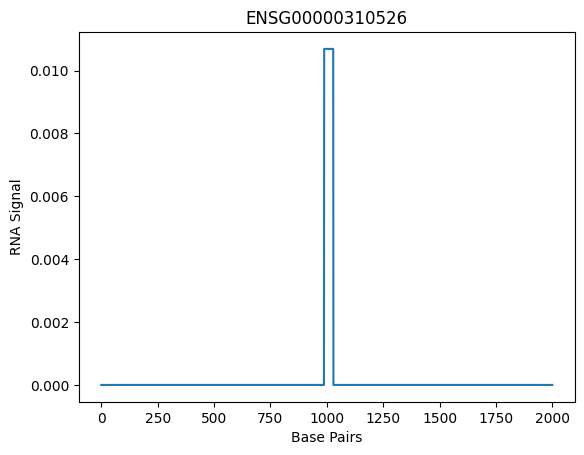

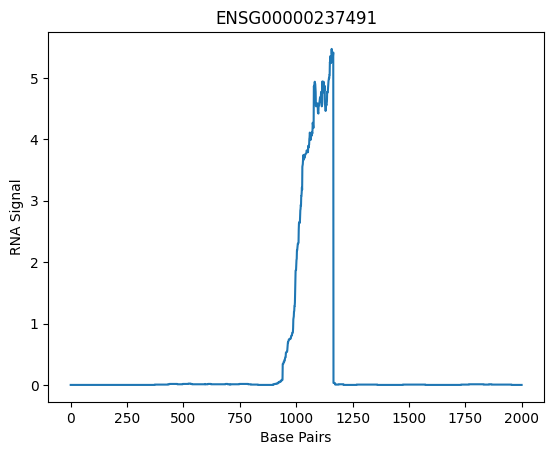

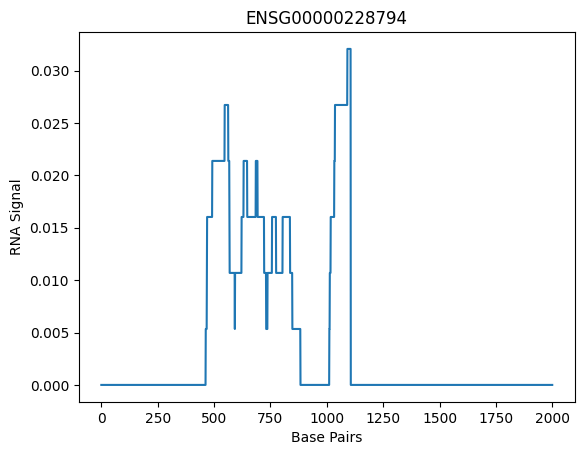

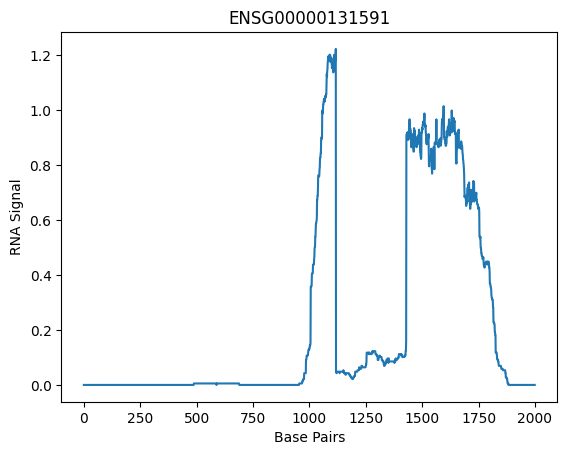

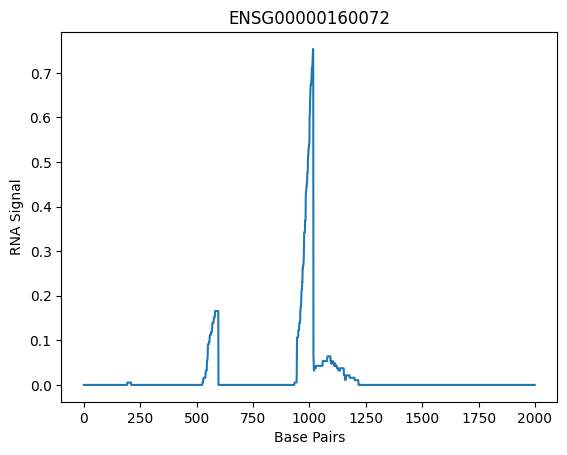

Threshold: 0.5
Number of Genes w/ Strong Peaks: 417


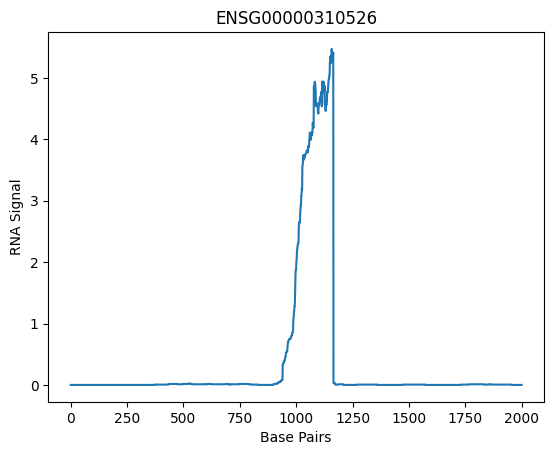

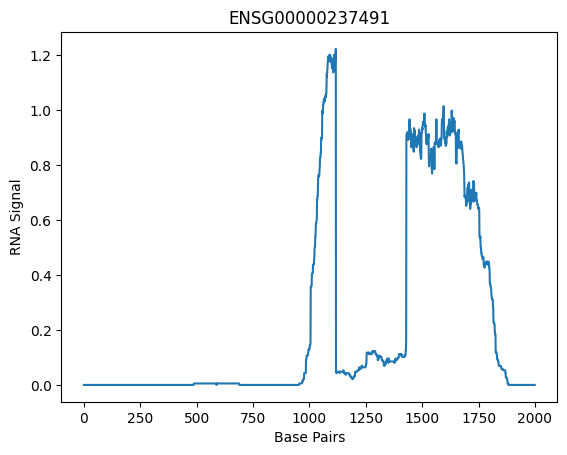

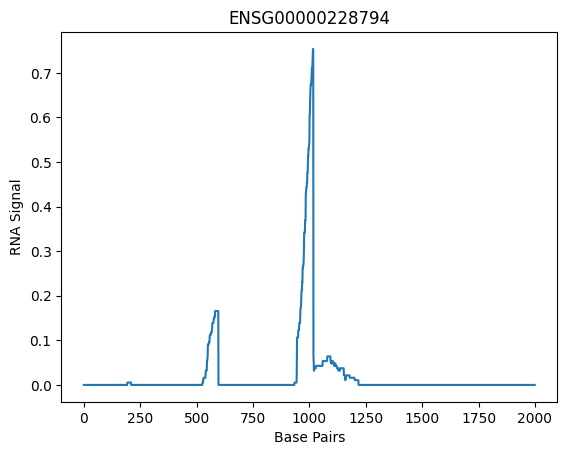

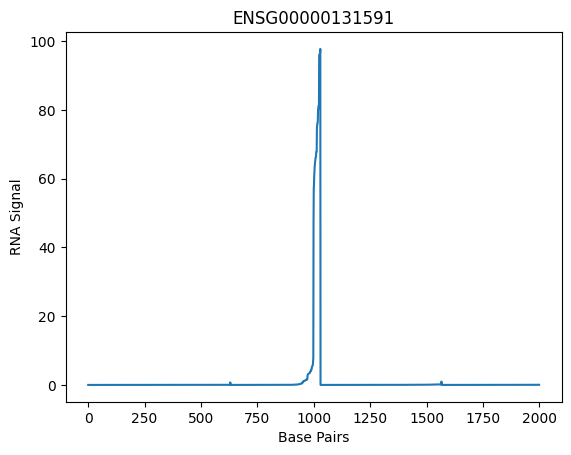

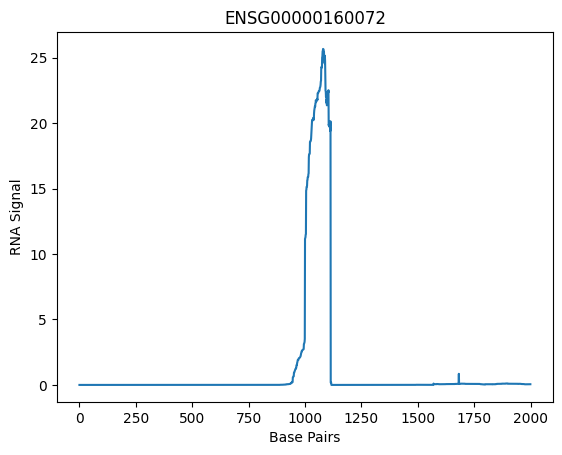

Threshold: 1.0
Number of Genes w/ Strong Peaks: 348


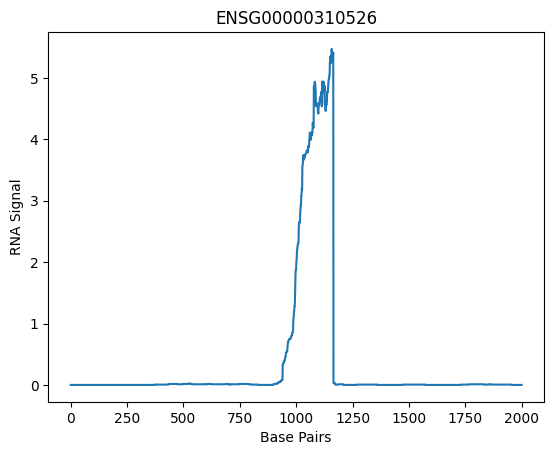

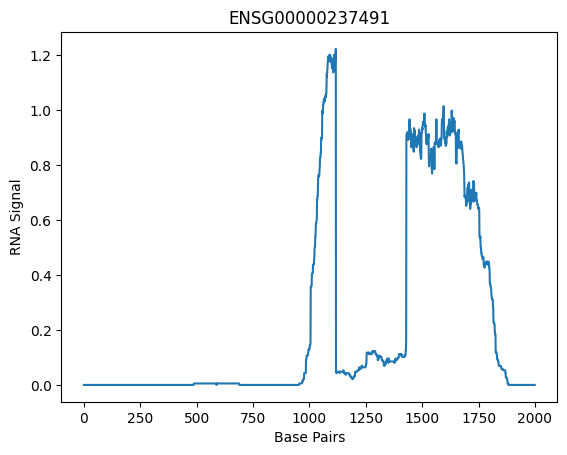

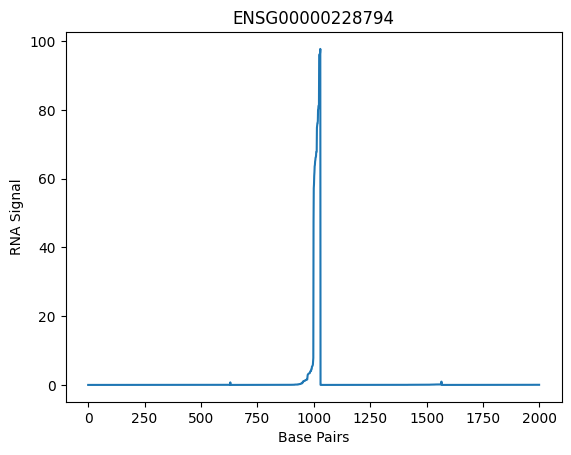

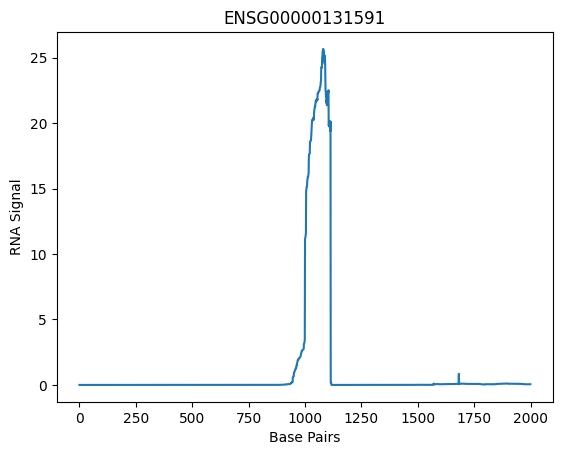

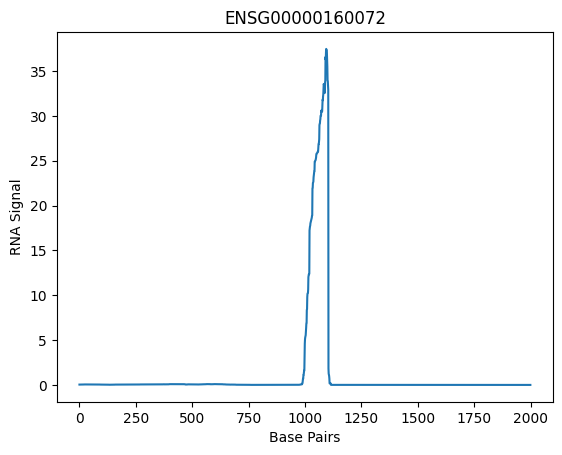

Threshold: 1.5
Number of Genes w/ Strong Peaks: 303


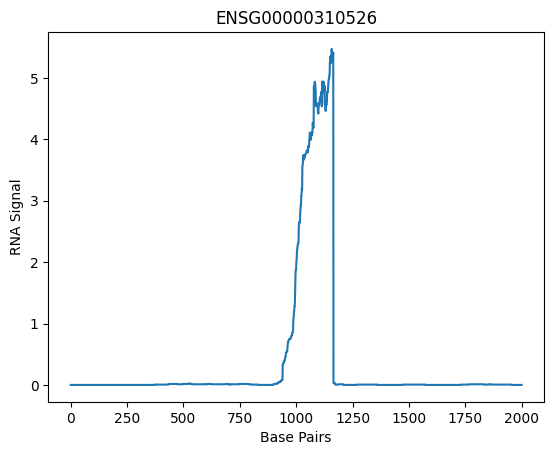

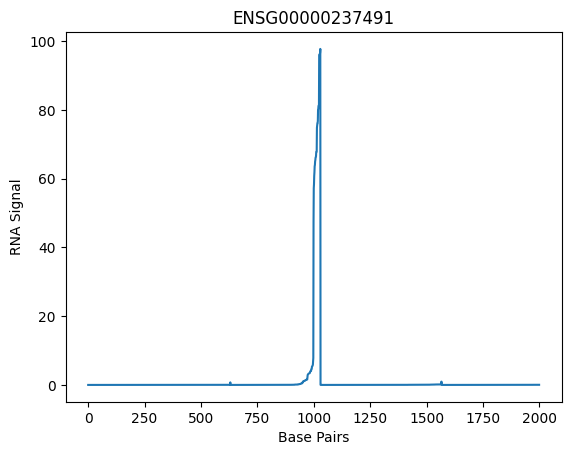

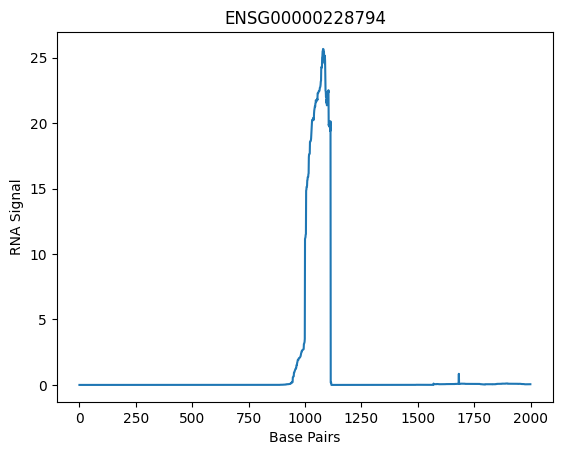

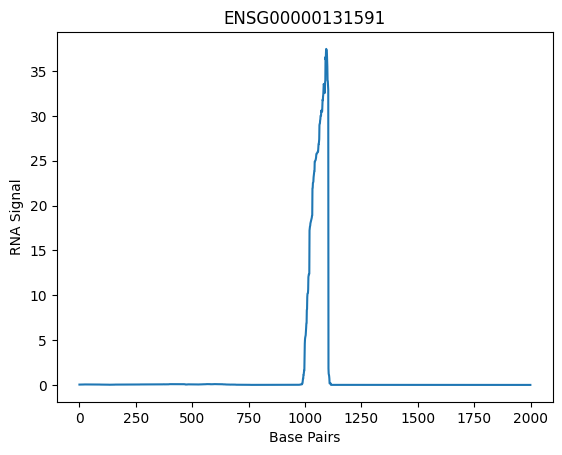

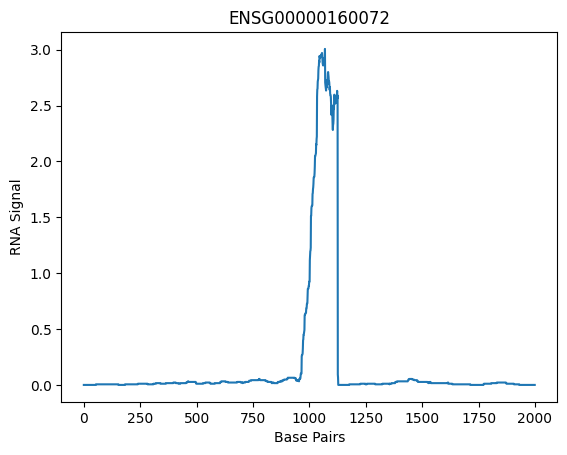

Threshold: 2.0
Number of Genes w/ Strong Peaks: 267


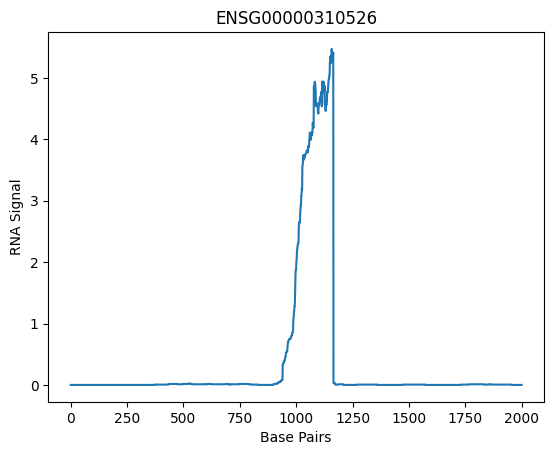

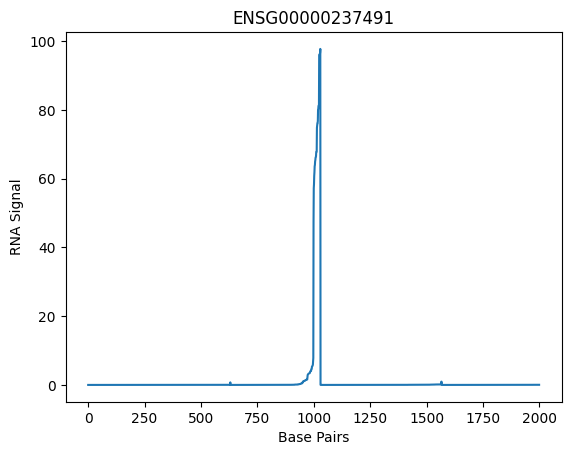

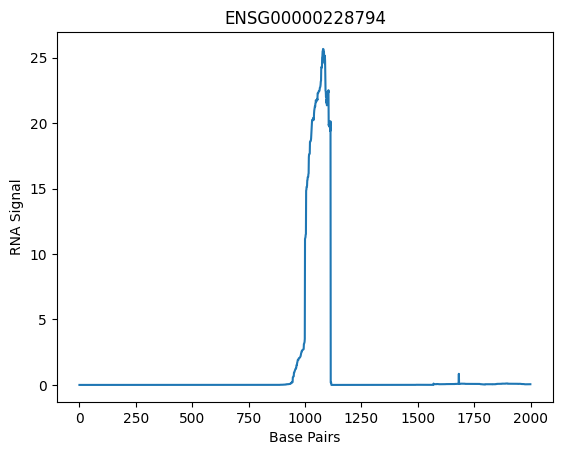

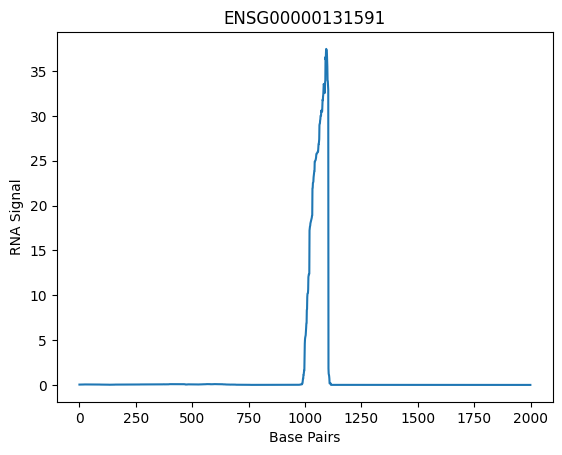

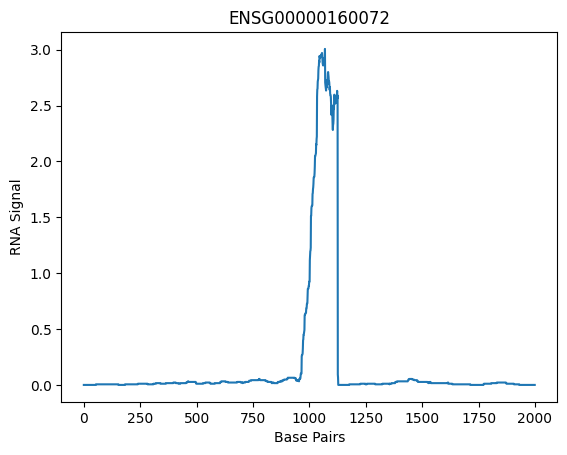

Threshold: 2.5
Number of Genes w/ Strong Peaks: 237


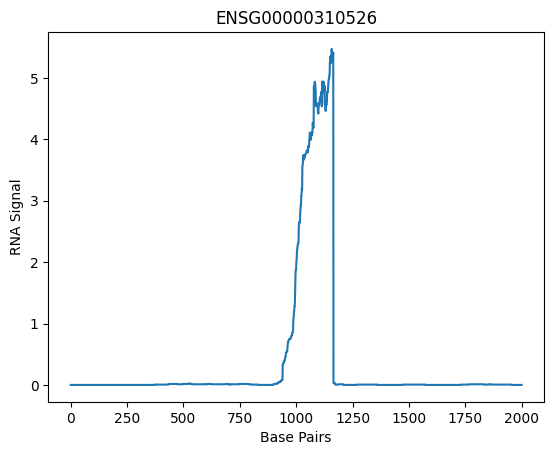

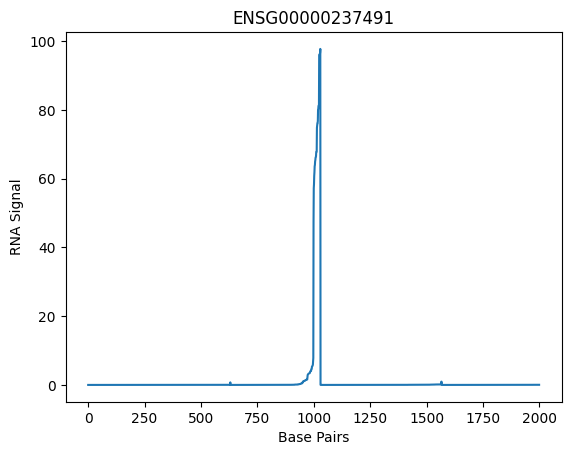

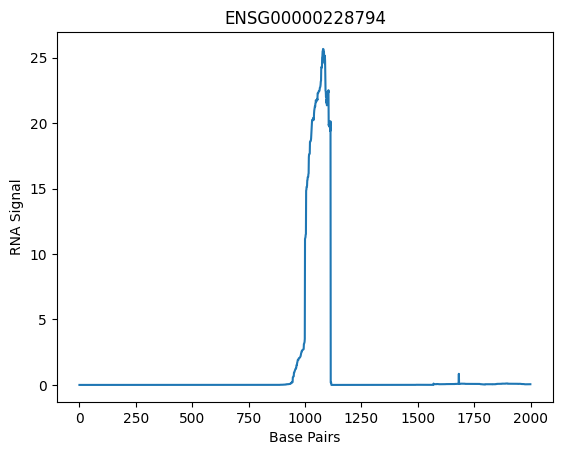

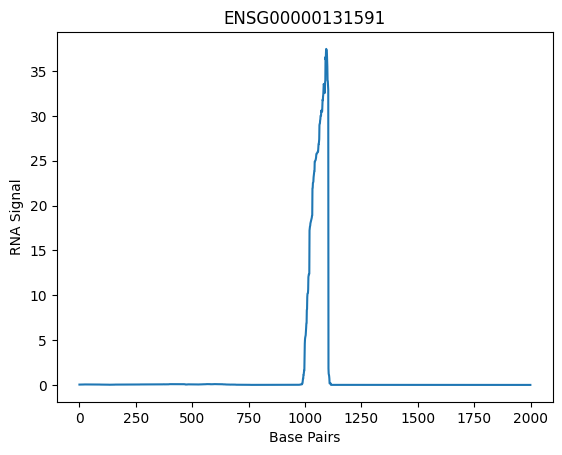

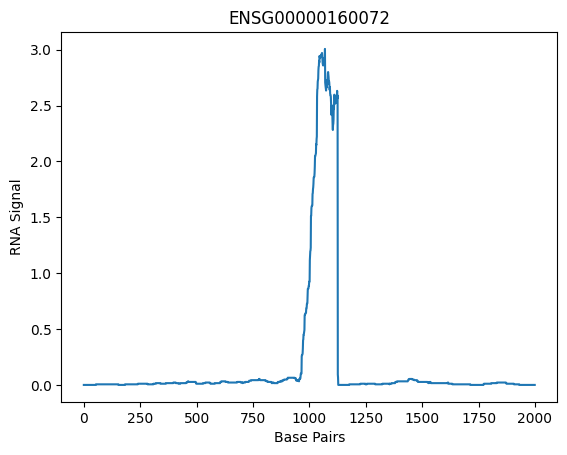

Threshold: 3.0
Number of Genes w/ Strong Peaks: 226


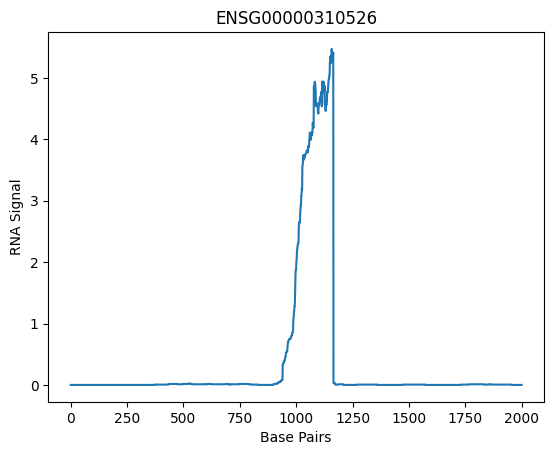

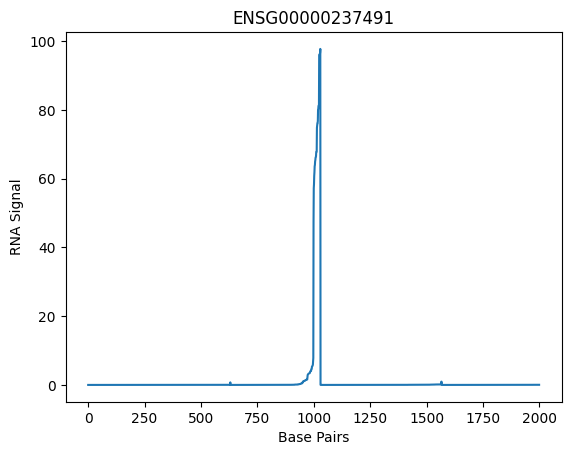

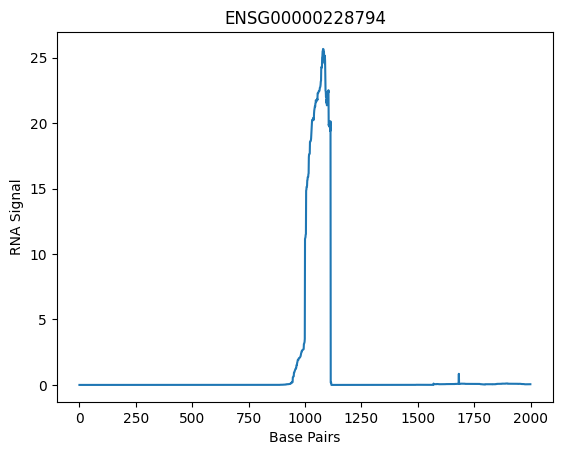

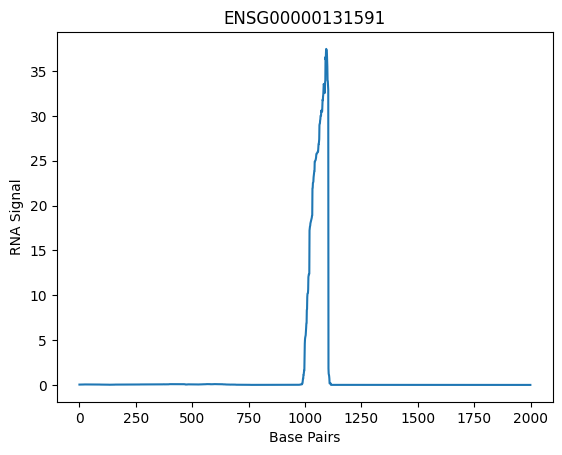

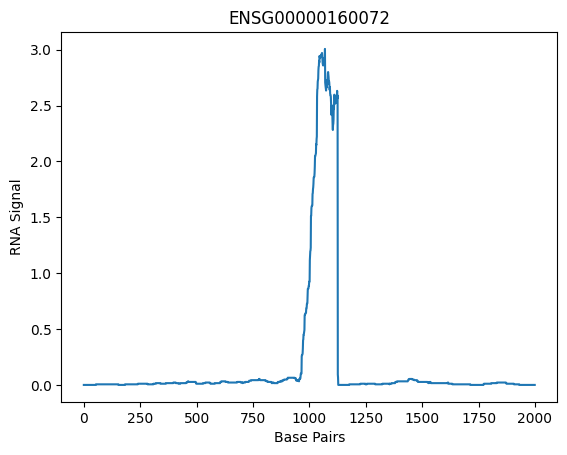

Threshold: 3.5
Number of Genes w/ Strong Peaks: 209


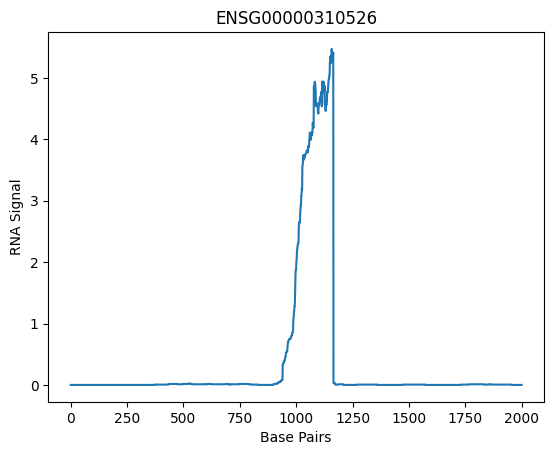

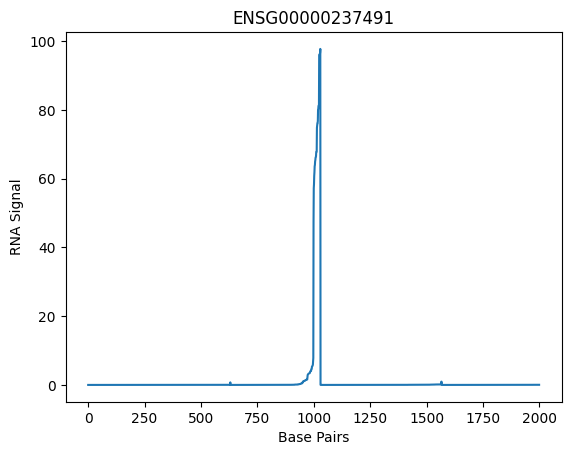

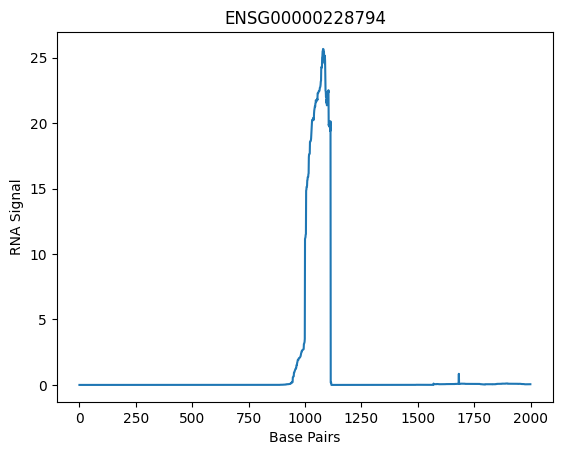

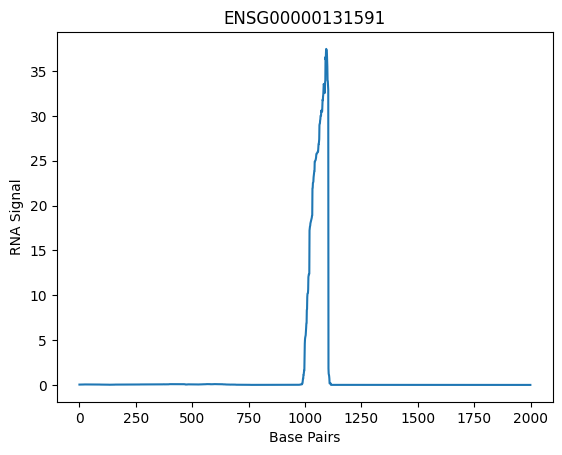

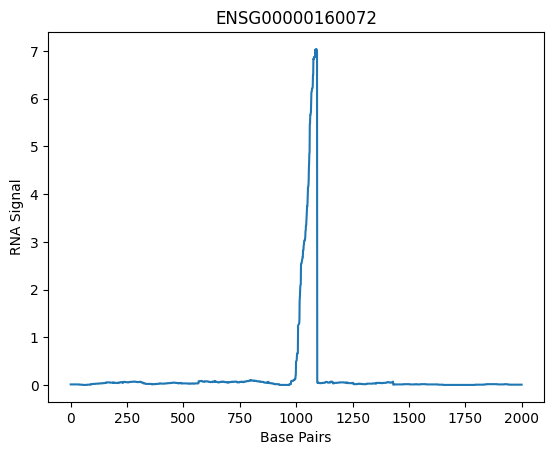

Threshold: 4.0
Number of Genes w/ Strong Peaks: 199


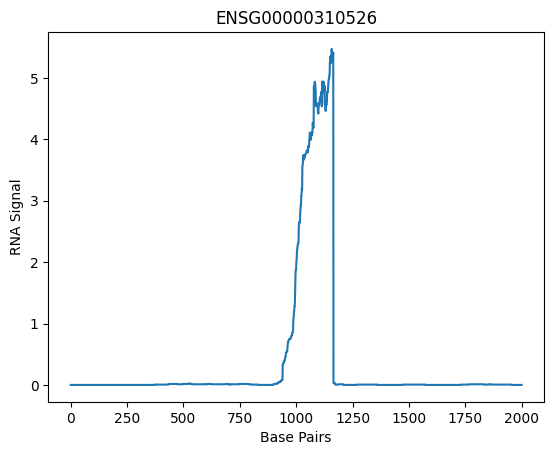

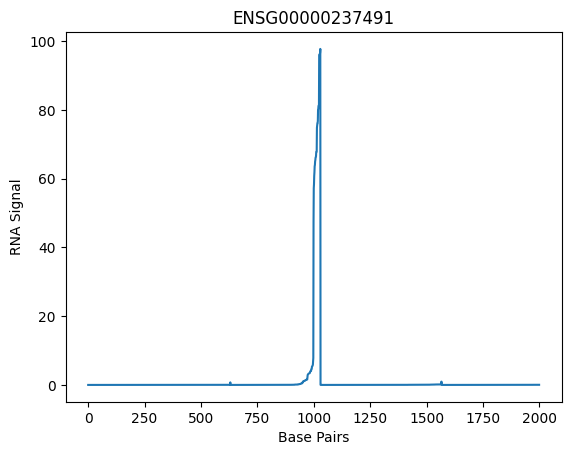

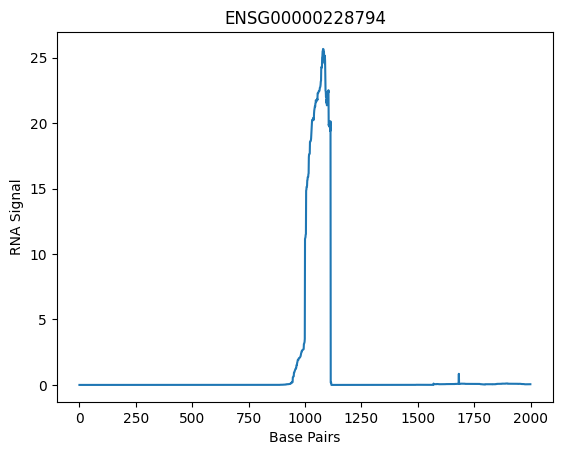

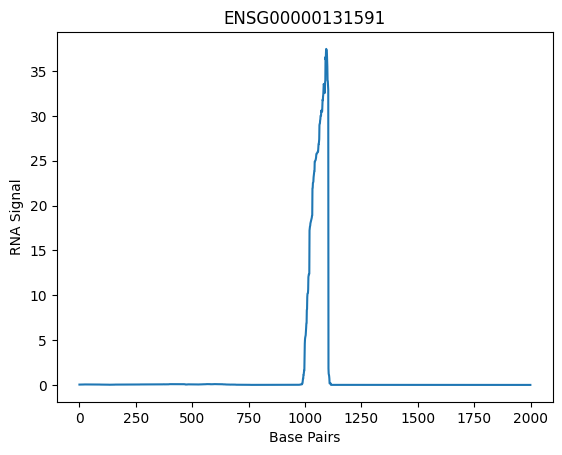

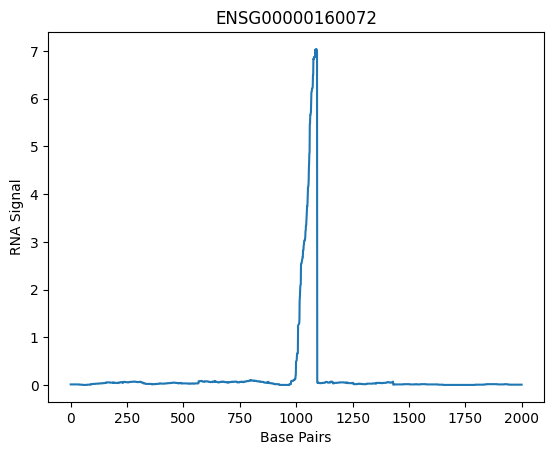

Threshold: 4.5
Number of Genes w/ Strong Peaks: 188


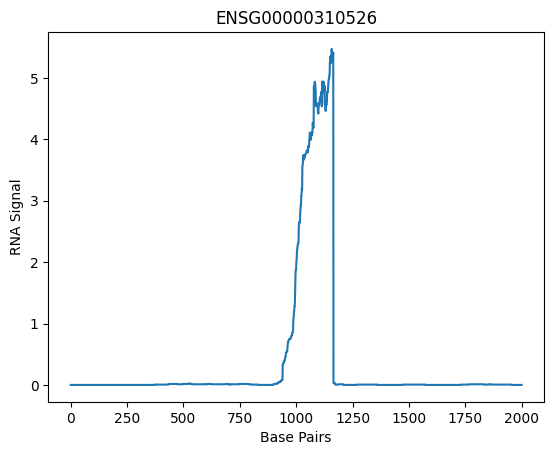

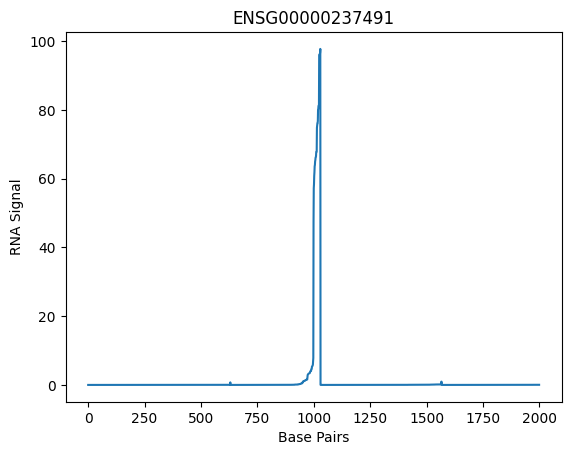

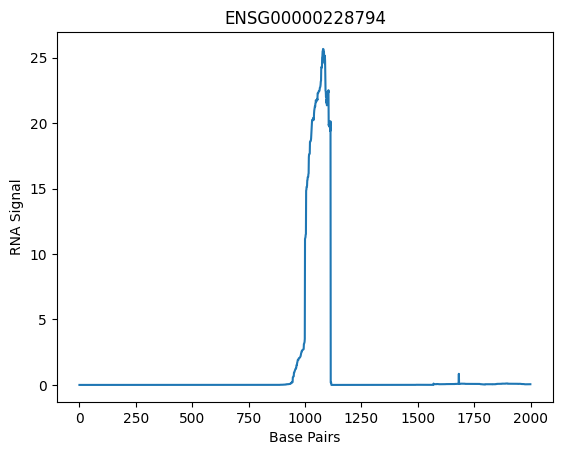

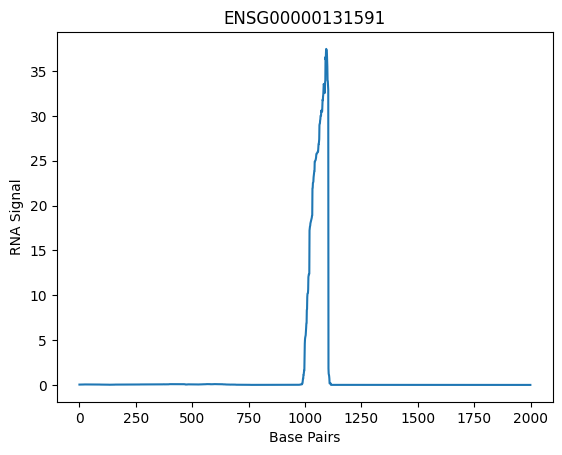

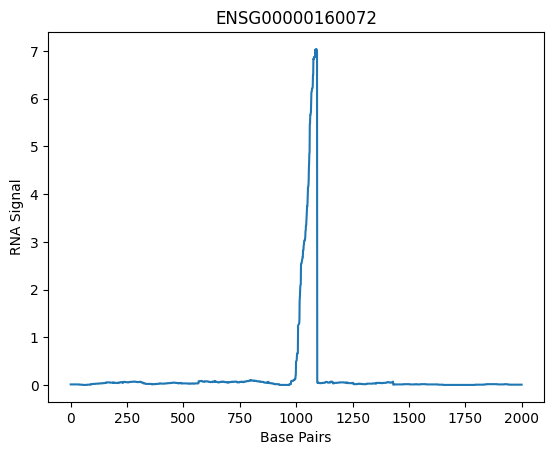

Threshold: 5.0
Number of Genes w/ Strong Peaks: 174


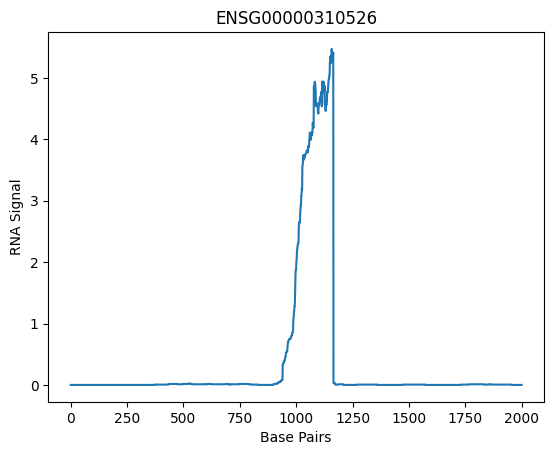

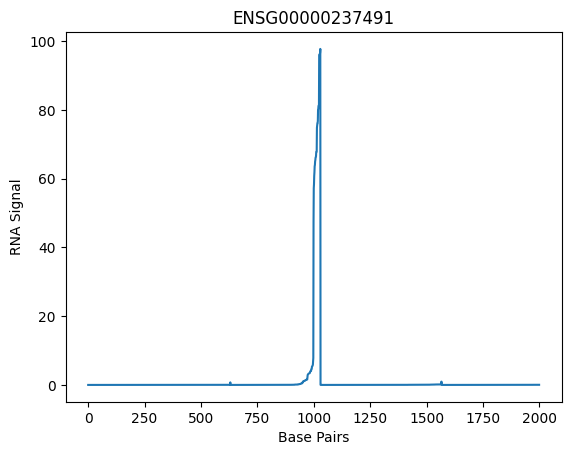

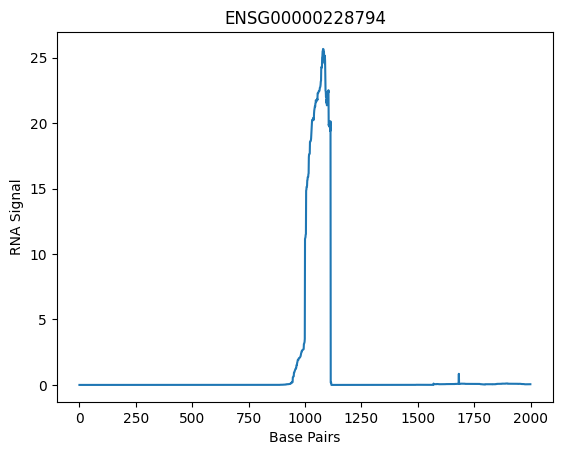

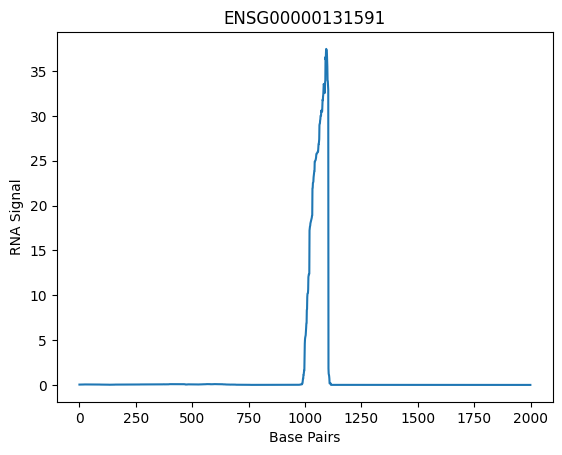

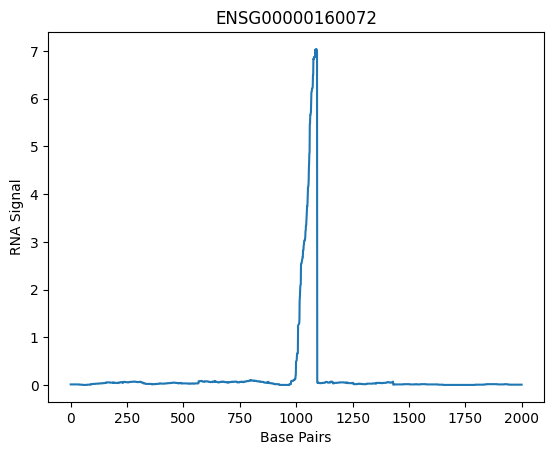

In [166]:
# K562
thresholds = np.linspace(0, 5, 11)
bool_df = [gene.decode() in list(fp_k5["ENSID"]) for gene in k5_h5["ensid"]]
rna = k5_h5["rna"][:][bool_df]
ensid = k5_h5["ensid"][:][bool_df]

peak_counts = []
for threshold in thresholds:
    peak = [ensid[idx].decode() for idx, sig in enumerate(rna) if np.max(sig) in sig[808:1192] and np.max(sig) > threshold]
    peak_bool = [gene.decode() in peak for gene in k5_h5["ensid"]]

    peak_counts.append(sum(peak_bool))
    print(f"Threshold: {threshold}\nNumber of Genes w/ Strong Peaks: {sum(peak_bool)}")
    for idx, gene in enumerate(k5_h5["rna"][:][peak_bool][0:5]):
        plt.title(ensid[idx].decode())
        plt.ylabel("RNA Signal")
        plt.xlabel("Base Pairs")
        plt.plot(gene)
        plt.show()

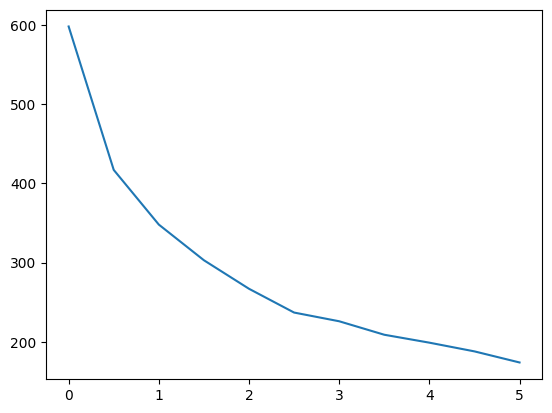

In [167]:
plt.plot(thresholds, peak_counts)

Aggregate Plots of Best Predictions

In [153]:
gm["Error"].quantile([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

0.01    0.007918
0.10    0.073478
0.25    0.158809
0.50    0.326479
0.75    0.609761
0.90    1.029975
0.99    2.301041
Name: Error, dtype: float64

Threshold: 0.01, with 352 genes.


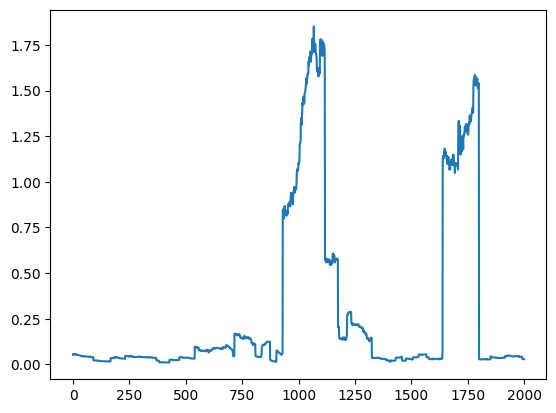

Threshold: 0.1, with 4133 genes.


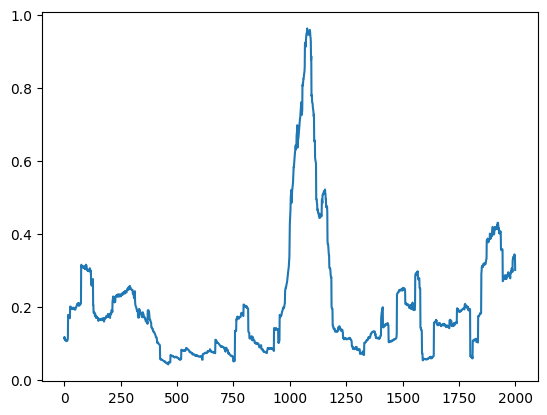

Threshold: 0.5, with 19039 genes.


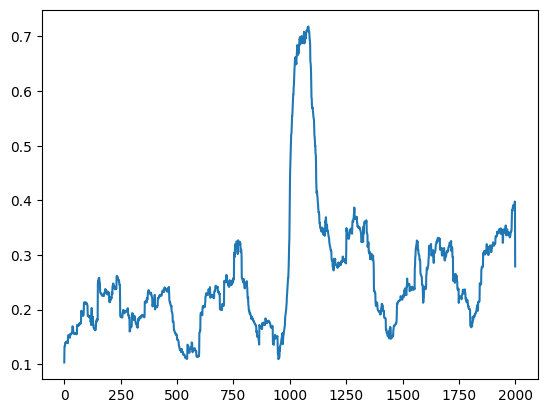

Threshold: 1, with 25345 genes.


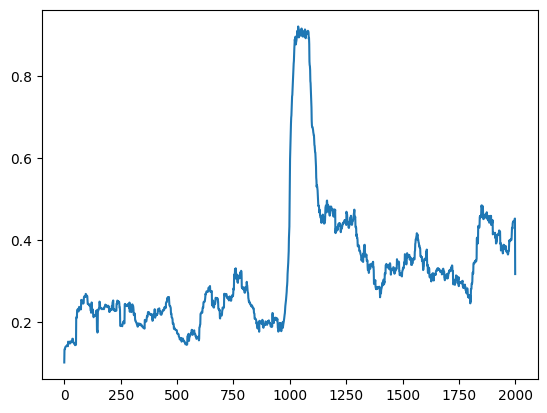

Threshold: 1.5, with 27110 genes.


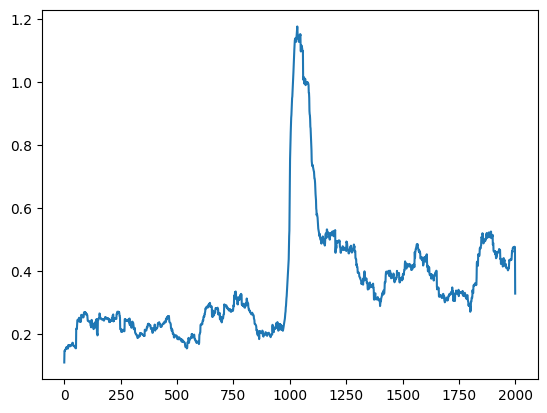

Threshold: 2, with 27823 genes.


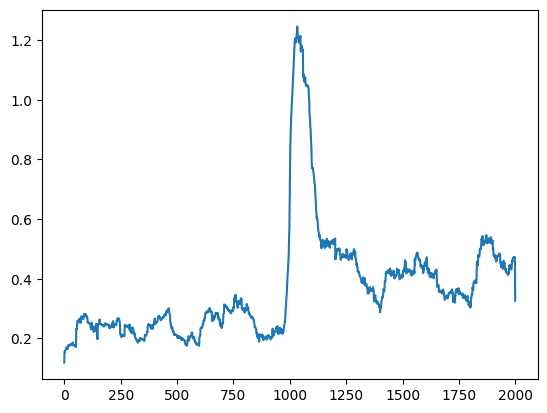

In [172]:
# GM12878
counts = []
thresholds = [0.01, 0.1, 0.5, 1, 1.5, 2]
for threshold in thresholds:
    best_gm = gm[gm["Error"] < threshold]

    bool_df = [gene.decode() in list(best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]
    ensid = gm_h5["ensid"][:][bool_df]
    rna = gm_h5["rna"][:][bool_df]

    counts.append(len(rna))
    print(f"Threshold: {threshold}, with {len(rna)} genes.")
    plt.plot(np.mean(rna, axis=0))
    plt.show()


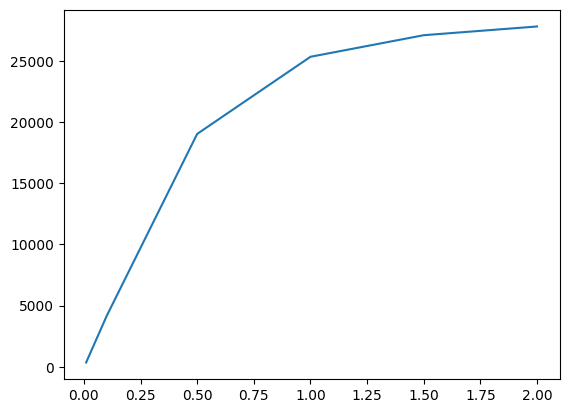

In [173]:
plt.plot(thresholds, counts)

Threshold: 0.01, with 348 genes.


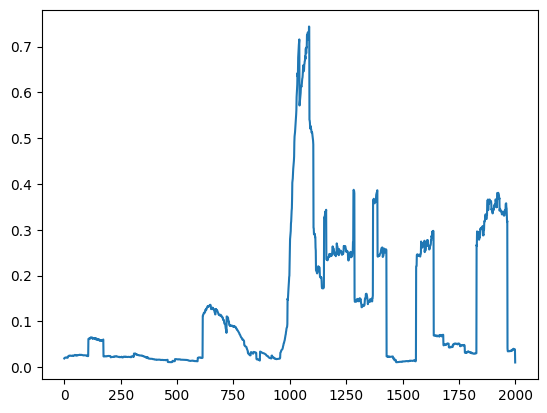

Threshold: 0.1, with 4986 genes.


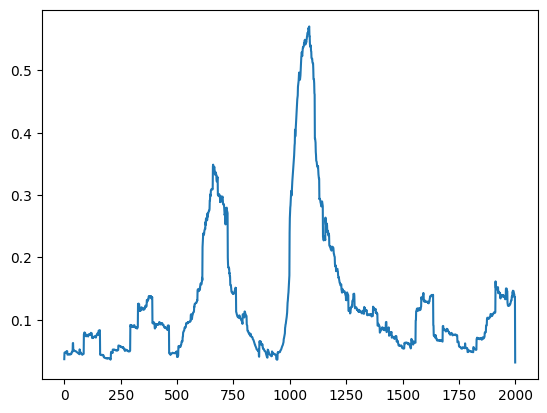

Threshold: 0.5, with 18665 genes.


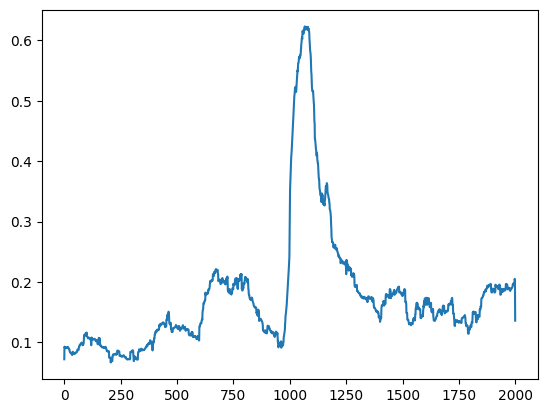

Threshold: 1, with 24744 genes.


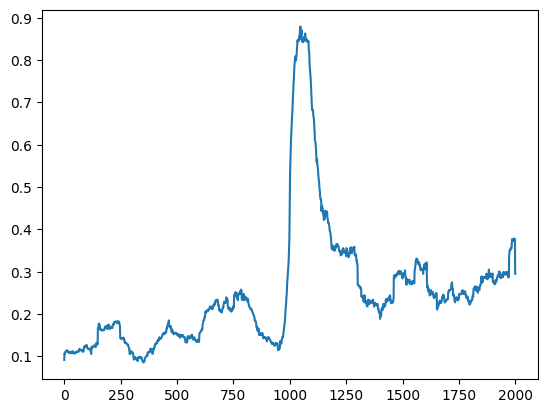

Threshold: 1.5, with 26684 genes.


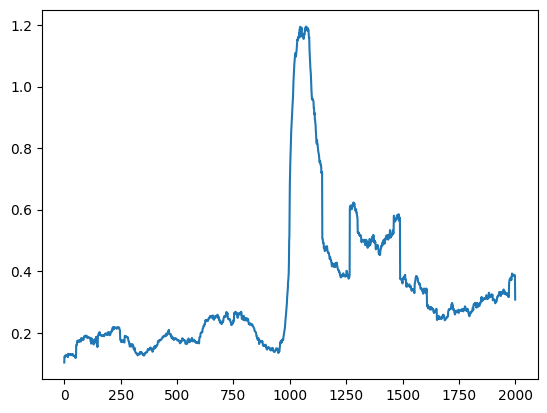

Threshold: 2, with 27615 genes.


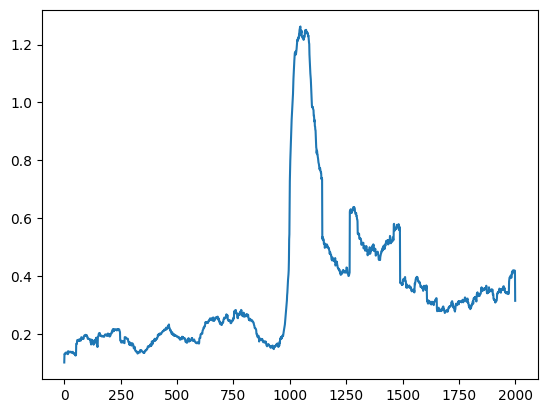

In [174]:
# K562
counts = []
thresholds = [0.01, 0.1, 0.5, 1, 1.5, 2]
for threshold in thresholds:
    best_k5 = k5[k5["Error"] < threshold]

    bool_df = [gene.decode() in list(best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]
    ensid = k5_h5["ensid"][:][bool_df]
    rna = k5_h5["rna"][:][bool_df]

    print(f"Threshold: {threshold}, with {len(rna)} genes.")
    counts.append(len(rna))
    plt.plot(np.mean(rna, axis=0))
    plt.show()

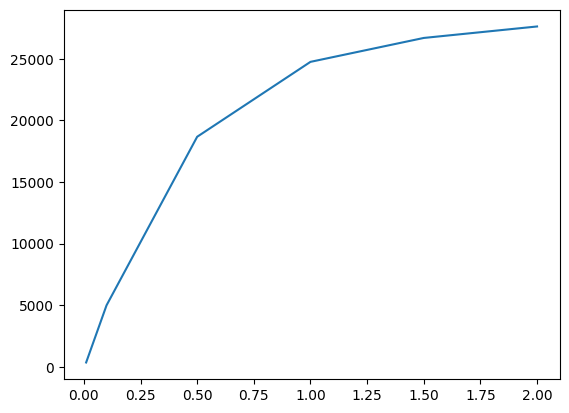

In [175]:
plt.plot(thresholds, counts)